<a href="https://colab.research.google.com/github/andyzihaozhang/Data-Science-Penn/blob/main/CIS545%20Final%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**<h1 align="center"> <font size="7"> Analysis of Lending Club Loan Data </font> </h1>**
#<center>Zihao Zhang <br></center>
###<center>Fall 2021</center>

# **0. Introduction and Setup**

![](https://digital.hbs.edu/platform-digit/wp-content/uploads/sites/2/2019/02/LC-Logo-Official-min.png)


In this project, we will use the Lending Club Loan Data 2007-11 dataset from Lending Club, one of the pioneer platforms in the peer-to-peer lending market. We would like to first clean the dataset and understand the context of each column and the correlation between these columns to pick the most reasonable features. Then, we will present the results of our explorative data analysis in the format of different data visualizations, such as bar chart, line chart, heatmap, and map. Finally, we will train several different models with different sets of parameters and compare the results to find the most suitable model and parameters to use. 
The ultimate objective is to choose and train two machine learning models to determine the default probability of a loan request and determine the interest rate of a loan request respectively. In this way, we not only be able to serve the risk-averse investors who are looking for safe investments with lower returns but also the risk-tolerant investors who are looking for higher returns and willing to take the underlying default risk.

In [ ]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 34.5 MB/s 
     |████████████████████████████████| 15.4 MB 31.7 MB/s 
     |████████████████████████████████| 6.3 MB 22.5 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas

from datetime import datetime as dt
from dateutil.relativedelta import relativedelta

pd.options.mode.chained_assignment = None

In [ ]:
df = pd.read_csv('https://query.data.world/s/u75xuiwhjsjovbjt6d6jepamoxhqjh', skiprows=1)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,49) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,...,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,735.0,739.0,1.0,NaN,NaN,3.0,0.0,13648.0,83.7%,9.0,f,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,740.0,744.0,5.0,NaN,NaN,3.0,0.0,1687.0,9.4%,4.0,f,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,735.0,739.0,2.0,NaN,NaN,2.0,0.0,2956.0,98.5%,10.0,f,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-1996,690.0,694.0,1.0,35.0,NaN,10.0,0.0,5598.0,21%,37.0,f,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-1996,695.0,699.0,0.0,38.0,NaN,15.0,0.0,27783.0,53.9%,38.0,f,270.78,270.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


# **1. Data Preprocessing**
In this section, we will drop rows that contain NULLs/abnormal cells in specific columns and convert/calculate new columns using existing columns. The dataset will be cleaned and prepared for the next steps.

In [ ]:
print("The dataset contains {} columns and {} rows before data cleaning.".format(df.shape[1], df.shape[0]))

The dataset contains 115 columns and 42538 rows before data cleaning.


### 1.1 Drop string type row in id

In [ ]:
df.isnull().sum().head(20)

id                         0
member_id                  3
loan_amnt                  3
funded_amnt                3
funded_amnt_inv            3
term                       3
int_rate                   3
installment                3
grade                      3
sub_grade                  3
emp_title               2629
emp_length              1115
home_ownership             3
annual_inc                 7
verification_status        3
issue_d                    3
loan_status                3
pymnt_plan                 3
url                        3
desc                   13296
dtype: int64

In [ ]:
df_raw = df[df['id'].astype(str).str.isdigit()]
print("The dataset now contains {} columns and {} rows.".format(df_raw.shape[1], df_raw.shape[0]))

The dataset now contains 115 columns and 42535 rows.


### 1.2 Normalize loan_status
In this section, we will normalize the loan_status column to "paid" and "default" and use only rows with these two labels.

In [ ]:
# Show distinct status
df_raw['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'In Grace Period',
       'Late (31-120 days)', 'Late (16-30 days)', 'Default',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [ ]:
# Create loan_status_map and apply
loan_status_map = {
    "Fully Paid": "paid",
    "Does not meet the credit policy. Status:Fully Paid": "paid",
    "Default": "default",
    "Charged Off": "default",
    "Does not meet the credit policy. Status:Charged Off": "default"
}

df_raw['loan_status'] = df_raw['loan_status'].apply(lambda x: loan_status_map.get(x))
df_raw['loan_status'].unique()

array(['paid', 'default', None], dtype=object)

### 1.3 Normalize emp_length
In this section, we will reduce the categories of emp_length based on the common division of employment length (0-2 years: new grad, 2-5 years: junior, 5-10 years: senior, 10+ years: manager or higher).

In [ ]:
# Show distinct length
df_raw['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [ ]:
# Create emp_length_map and apply
emp_length_map = {
    "n/a": "0-2 years",
    "< 1 year": "0-2 years",
    "1 year": "0-2 years",
    "2 years": "2-5 years",
    "3 years": "2-5 years",
    "4 years": "2-5 years",
    "5 years": "5-10 years",
    "6 years": "5-10 years",
    "7 years": "5-10 years",
    "8 years": "5-10 years",
    "9 years": "5-10 years",
    "10+ years": "10+ years"
}

df_raw['emp_length'] = df_raw['emp_length'].apply(lambda x: emp_length_map.get(x))
df_raw['emp_length'].unique()

array(['10+ years', '0-2 years', '2-5 years', '5-10 years', None],
      dtype=object)

### 1.4 Convert data type
In this section, convert the percentage string of revol_util and int_rate to float type.

In [ ]:
df_raw = df_raw[df_raw.revol_util.isnull()==False]
df_raw['revol_util'] = df_raw['revol_util'].apply(lambda x: float(x[:-1])/100)
df_raw['int_rate'] = df_raw['int_rate'].apply(lambda x: float(x.lstrip()[:-1])/100)

df_raw.astype({"revol_util": float, "int_rate": float})

print("The dataset now contains {} columns and {} rows.".format(df_raw.shape[1], df_raw.shape[0]))

The dataset now contains 115 columns and 42445 rows.


### 1.5 Convert FICO range to score
In this section, calculate the average of fico_range_high and fico_range_low as a new column fico_score.

In [ ]:
df_raw.astype({"fico_range_high": int, "fico_range_low": int})
df_raw['fico_score'] = (df_raw['fico_range_high'] + df_raw['fico_range_low']) / 2

### 1.6 Calculate credit_length
In this section, calculate the difference between issue_d and earliest_cr_line as credit_length in days.

In [ ]:
# Convert the date string date to datetime object
df_raw['issue_d'] = df_raw.issue_d.apply(lambda x: dt.strptime(x, "%b-%Y"))
df_raw['earliest_cr_line'] = df_raw.earliest_cr_line.apply(lambda x: dt.strptime(x, "%b-%Y"))

# Calculate the credit length and convert it to day format
df_raw['credit_length'] = df_raw['issue_d'] - df_raw['earliest_cr_line']
df_raw['credit_length'] = df_raw['credit_length'].apply(lambda x: x.days)

### 1.7 Get geospatial and population data

In [ ]:
# Initiate US map with a shape file
usmap = geopandas.read_file("https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json")

# Create US State abbreviation dictionary using internet resources
abbr2state_df = pd.read_html('https://abbreviations.yourdictionary.com/articles/state-abbrev.html', header=0)[0]
abbr2state_df = abbr2state_df[['State Name', 'USPS Abbreviation']]
abbr2state_df.set_index(["USPS Abbreviation"], inplace=True)
abbr2state = abbr2state_df.to_dict()['State Name']
abbr2state['DC'] = "District of Columbia"

In [ ]:
# Get 2010 US population by states
population_by_state = pd.read_html('https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_population#State_and_territory_rankings', 
                                   header=1)[0]
population_by_state = population_by_state[['State or territory', 'April 1, 2010']]
population_by_state = population_by_state.rename(columns={'State or territory': 'State', 'April 1, 2010': '2010 Population'})
population_by_state.head()

,State,2010 Population
0,California,37253956
1,Texas,25145561
2,Florida,18801310
3,New York,19378102
4,Pennsylvania,12702379


# **2. Feature Selection**
In this section, we will continue our analysis only with columns that we believe to be relevant features to loan paid/default and interest rate.



### 2.1 Column Definition


*   annual_inc: The self-reported annual income provided by the borrower during registration.
*   credit_length: The days between the the loan issue date (issue_d) and the date that borrower got his/her first credit line (earliest_cr_line).
*   delinq_2yrs: The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years.
*   delinq_amnt: The past-due amount owed for the accounts on which the borrower is now delinquent.
*   dti: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
*   emp_length: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
*   fico_score: The avarege of upper/lower boundary range the borrower’s FICO at loan origination belongs to.
*   funded_amnt: The total amount committed to that loan at that point in time.
*   home_ownership: The home ownership status provided by the borrower during registration.
*   inq_last_6mths: The number of inquiries in past 6 months (excluding auto and mortgage inquiries).
*   int_rate: Interest Rate on the loan.
*   loan_status: Current status of the loan.
*   loan_amnt: The listed amount of the loan applied for by the borrower.
*   pub_rec: Number of derogatory public records.
*   revol_bal: Total credit revolving balance.
*   revol_util: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
*   term: The number of payments on the loan.
*   total_acc: The total number of credit lines currently in the borrower's credit file.
*   verification_status: Indicates if income was verified by LC, not verified, or if the income source was verified.

In [ ]:
# EDA columns
eda_cols = ["loan_amnt", "funded_amnt", "term", "emp_length", "home_ownership",
            "annual_inc", "verification_status", "dti", "delinq_2yrs", 
            "fico_score", "pub_rec", "revol_bal", "revol_util", 
            "total_acc", "delinq_amnt", "inq_last_6mths", "credit_length",
            "loan_status", "int_rate", "addr_state", "issue_d"]

# Final columns        
feature_cols = ["funded_amnt", "term", "emp_length", "home_ownership", 
                "annual_inc", "verification_status", "dti", "delinq_2yrs", 
                "fico_score", "pub_rec", "revol_bal", "revol_util", 
                "total_acc", "delinq_amnt", "inq_last_6mths", "credit_length",
                "loan_status", "int_rate"]

df_eda = df_raw[eda_cols]

df_eda.head()

,loan_amnt,funded_amnt,term,emp_length,home_ownership,annual_inc,verification_status,dti,delinq_2yrs,fico_score,pub_rec,revol_bal,revol_util,total_acc,delinq_amnt,inq_last_6mths,credit_length,loan_status,int_rate,addr_state,issue_d
0,5000.0,5000.0,36 months,10+ years,RENT,24000.0,Verified,27.65,0.0,737.0,0.0,13648.0,0.837,9.0,0.0,1.0,9830,paid,0.1065,AZ,2011-12-01
1,2500.0,2500.0,60 months,0-2 years,RENT,30000.0,Source Verified,1.00,0.0,742.0,0.0,1687.0,0.094,4.0,0.0,5.0,4627,default,0.1527,GA,2011-12-01
2,2400.0,2400.0,36 months,10+ years,RENT,12252.0,Not Verified,8.72,0.0,737.0,0.0,2956.0,0.985,10.0,0.0,2.0,3682,paid,0.1596,IL,2011-12-01
3,10000.0,10000.0,36 months,10+ years,RENT,49200.0,Source Verified,20.00,0.0,692.0,0.0,5598.0,0.210,37.0,0.0,1.0,5782,paid,0.1349,CA,2011-12-01
4,3000.0,3000.0,60 months,0-2 years,RENT,80000.0,Source Verified,17.94,0.0,697.0,0.0,27783.0,0.539,38.0,0.0,0.0,5813,None,0.1269,OR,2011-12-01


TODO: Reasoning for Feature Selection

### 2.2 Drop Row with NULLs

In [ ]:
df_eda = df_eda.dropna(subset=feature_cols)
print("The dataset now contains {} columns and {} rows.".format(df_eda.shape[1], df_eda.shape[0]))

The dataset now contains 21 columns and 40811 rows.


### 2.3 Display Columns Info

In [ ]:
df_eda.dtypes

loan_amnt                     float64
funded_amnt                   float64
term                           object
emp_length                     object
home_ownership                 object
annual_inc                    float64
verification_status            object
dti                           float64
delinq_2yrs                   float64
fico_score                    float64
pub_rec                       float64
revol_bal                     float64
revol_util                    float64
total_acc                     float64
delinq_amnt                   float64
inq_last_6mths                float64
credit_length                   int64
loan_status                    object
int_rate                      float64
addr_state                     object
issue_d                datetime64[ns]
dtype: object

In [ ]:
df_eda.describe()

,loan_amnt,funded_amnt,annual_inc,dti,delinq_2yrs,fico_score,pub_rec,revol_bal,revol_util,total_acc,delinq_amnt,inq_last_6mths,credit_length,int_rate
count,40811.000000,40811.000000,4.081100e+04,40811.000000,40811.000000,40811.000000,40811.000000,4.081100e+04,40811.000000,40811.000000,40811.000000,40811.000000,40811.000000,40811.000000
mean,11079.692362,10809.785965,6.970001e+04,13.368723,0.153169,714.722428,0.056896,1.436092e+04,0.491718,22.152483,0.148979,1.088236,4932.746392,0.121527
std,7351.214961,7086.184403,6.476814e+04,6.714830,0.514040,36.065315,0.243509,2.219099e+04,0.283579,11.591687,29.963071,1.537311,2445.023673,0.036817
min,500.000000,500.000000,1.896000e+03,0.000000,0.000000,612.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,184.000000,0.054200
25%,5300.000000,5200.000000,4.100000e+04,8.200000,0.000000,687.000000,0.000000,3.667000e+03,0.258000,13.000000,0.000000,0.000000,3257.000000,0.096300
50%,9800.000000,9600.000000,6.000000e+04,13.470000,0.000000,712.000000,0.000000,8.866000e+03,0.497000,20.000000,0.000000,1.000000,4534.000000,0.119900
75%,15000.000000,15000.000000,8.300400e+04,18.660000,0.000000,742.000000,0.000000,1.728750e+04,0.728000,29.000000,0.000000,2.000000,6147.000000,0.146700
max,35000.000000,35000.000000,6.000000e+06,29.990000,13.000000,827.000000,5.000000,1.207359e+06,1.190000,90.000000,6053.000000,33.000000,23892.000000,0.245900


### 2.4 Columns Correlation

In [ ]:
df_eda.corr()

,loan_amnt,funded_amnt,annual_inc,dti,delinq_2yrs,fico_score,pub_rec,revol_bal,revol_util,total_acc,delinq_amnt,inq_last_6mths,credit_length,int_rate
loan_amnt,1.000000,0.981369,0.273002,0.061321,-0.034734,0.137588,-0.047510,0.250562,0.062112,0.255820,-0.004078,-0.028059,0.220980,0.286678
funded_amnt,0.981369,1.000000,0.268867,0.060977,-0.035245,0.129656,-0.048381,0.246746,0.066026,0.249837,-0.004042,-0.027852,0.215336,0.289418
annual_inc,0.273002,0.268867,1.000000,-0.117887,0.020558,0.056703,-0.013113,0.281619,0.018980,0.244847,-0.001871,0.028404,0.202671,0.050285
dti,0.061321,0.060977,-0.117887,1.000000,-0.036955,-0.192824,-0.002941,0.189803,0.279793,0.241444,-0.009462,0.012733,0.064072,0.120764
delinq_2yrs,-0.034734,-0.035245,0.020558,-0.036955,1.000000,-0.218580,0.013378,-0.043278,-0.045810,0.067306,0.123750,0.021657,0.067441,0.154905
fico_score,0.137588,0.129656,0.056703,-0.192824,-0.218580,1.000000,-0.151566,-0.022350,-0.541524,0.110827,-0.010020,-0.136691,0.236517,-0.704122
pub_rec,-0.047510,-0.048381,-0.013113,-0.002941,0.013378,-0.151566,1.000000,-0.045789,0.056896,-0.010435,-0.001162,0.059966,0.051497,0.102248
revol_bal,0.250562,0.246746,0.281619,0.189803,-0.043278,-0.022350,-0.045789,1.000000,0.233596,0.273919,-0.003189,0.008947,0.237458,0.081596
revol_util,0.062112,0.066026,0.018980,0.279793,-0.045810,-0.541524,0.056896,0.233596,1.000000,-0.054672,-0.001460,-0.041545,-0.022820,0.453824
total_acc,0.255820,0.249837,0.244847,0.241444,0.067306,0.110827,-0.010435,0.273919,-0.054672,1.000000,-0.000496,0.093242,0.400105,-0.030665


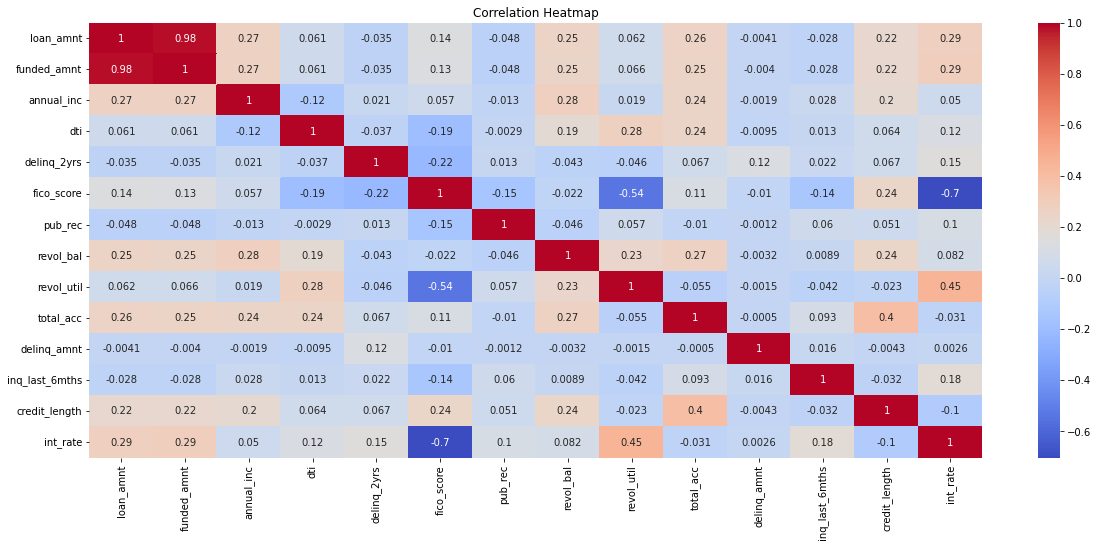

In [ ]:
plt.figure(figsize = (20,8))
sns.heatmap(df_eda.corr(), annot = True, fmt='.2g',cmap= 'coolwarm')
plt.title("Correlation Heatmap")
plt.show()

The loan amount and funded amount are highly positively correlated, so we can drop funded amount to reduce collinearity. The FICO score, which evaluates a borrower's creditworthiness, is 70% negatively correlated with the interest rate assigned to his or her loan request. This suggests that higher credit borrowers with lower risk to default tend to get lower interest rate for their loan. Because the platform can be more confident someone with a higher credit score will repay the debt in full and on time, it doesn't need to guarantee returns with a high interest rate. 

# **3. Explorative Data Analysis**
In this section, we will look into different perspectives of this dataset, such as the summary statistics of handpicked features, correlations between columns, data visualizations of some interesting features.

### 3.1 Loan Status

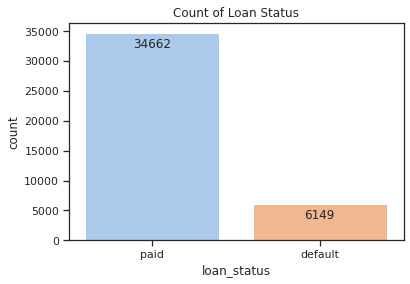

In [ ]:
# Plot the count of loan status
sns.set_theme(style="ticks", palette="pastel")
ax = sns.countplot(x="loan_status", data=df_eda)
ax.set_title("Count of Loan Status")

# Plot the text label of count
for i, p in enumerate(ax.patches):
    ax.text(p.get_x()+p.get_width()/2, p.get_height()-2500, df_eda['loan_status'].value_counts()[i], ha="center")

plt.show()

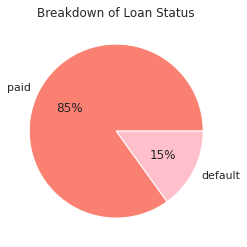

In [ ]:
# Plot the pie chart of loan status
ax = df_eda['loan_status'].value_counts().plot(kind='pie', colors=['salmon', 'pink'], autopct='%1.0f%%')
ax.set_title("Breakdown of Loan Status")
ax.yaxis.set_visible(False)
plt.show()

85% of loans have been paid in full, and the loan default rate through the platform is 15%. 

Default rates are an important statistical measure used by lenders to determine their exposure to risk. If a financial institution is found to have a high default rate in their loan portfolio, they may be forced to reassess their lending procedures in order to reduce their credit risk–the possibility of a loss resulting from a borrower's failure to repay a loan or meet contractual obligations. The default rate is also used by economists to evaluate the overall health of the economy.

### 3.2 Term Length
Display a barchart of counts for each term length. <br>
There are two kinds of term length, 36 months and 60 months. 75% of loans are 36 months.

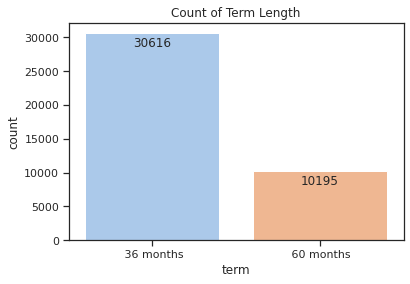

In [ ]:
# Plot the count of term length
sns.set_theme(style="ticks", palette="pastel")
ax = sns.countplot(x="term", data=df_eda)
ax.set_title("Count of Term Length")

# Plot the text label of count
for i, p in enumerate(ax.patches):
    ax.text(p.get_x()+p.get_width()/2, p.get_height()-2000, df_eda['term'].value_counts()[i], ha="center")

plt.show()

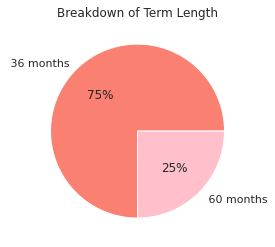

In [ ]:
# Plot the pie chart of term length
ax = df_eda['term'].value_counts().plot(kind='pie', colors=['salmon', 'pink'], autopct='%1.0f%%')
ax.set_title("Breakdown of Term Length")
ax.yaxis.set_visible(False)

### 3.3 FICO Score and Interest Rate
Display a histogram of FICO score in each range (Poor: 300-579, Fair: 580-669, Good: 670-739, Very good: 740-799, Exceptional: 800-850) and interest rate.

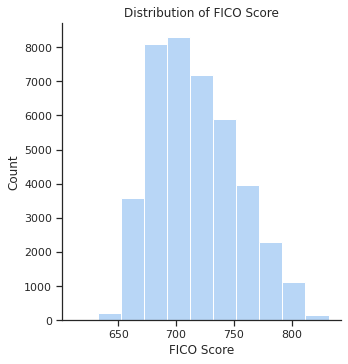

In [ ]:
# Plot the histogram of FICO score
sns.set_theme(style="ticks", palette="pastel")
fig = sns.displot(df_eda, x="fico_score", binwidth=20)
plt.xlabel("FICO Score")
plt.title("Distribution of FICO Score")
plt.show(fig)

The FICO score distribution follows a slightly right-skewed bell curve. Most of borrowers' credit scores have fallen into "Good" and "Very good" categories. 

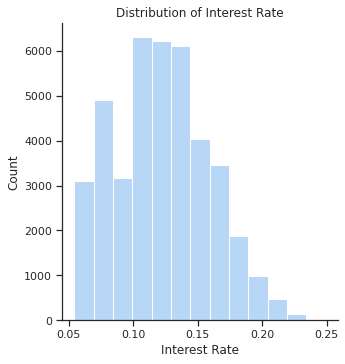

In [ ]:
# Plot the histogram of interest rate
sns.set_theme(style="ticks", palette="pastel")
fig = sns.displot(df_eda, x="int_rate", binwidth=0.015)
plt.xlabel("Interest Rate")
plt.title("Distribution of Interest Rate")
plt.show(fig)

Remember from the correlation analysis that interest rates are negatively correlated with FICO scores. Compare the two distribution shapes, we find that they don't seem to be mirror images for one another, suggesting other important factors in determining interest rates. 

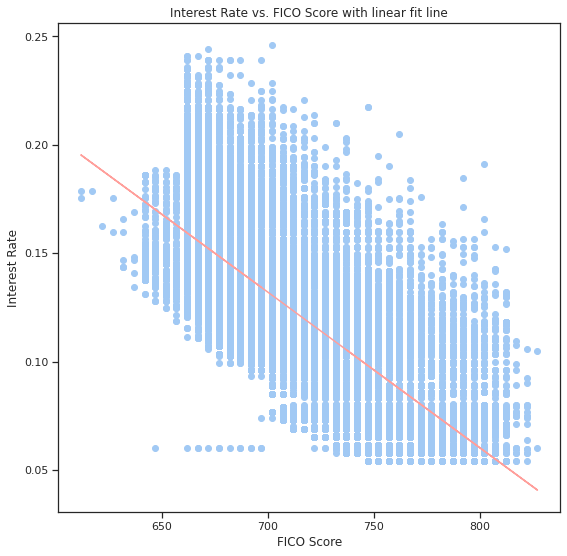

In [ ]:
# Calculate the coefficient of linear fit line
theta = np.polyfit(df_eda['fico_score'], df_eda['int_rate'], 1)
y = theta[1] + theta[0] * df_eda['fico_score']

# Plot the scatter plot of interest rate vs. FICO score with linear fit line
plt.figure(figsize=(9, 9))
plt.scatter(df_eda['fico_score'], df_eda['int_rate'])
plt.plot(df_eda['fico_score'], y, 'r')
plt.xlabel("FICO Score")
plt.ylabel("Interest Rate")
plt.title("Interest Rate vs. FICO Score with linear fit line")
plt.show()

### 3.4 Employment Status
Display a piechart of employment length (0-2 years, 2-5 years, 5-10 years, 10+ years).

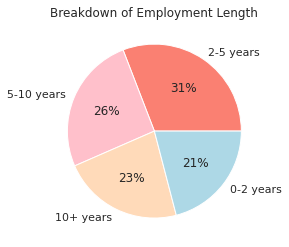

In [ ]:
# Plot the pie chart of employment length
ax = df_eda['emp_length'].value_counts().plot(kind='pie', colors=['salmon', 'pink', 'peachpuff', 'lightblue'], autopct='%1.0f%%')
ax.set_title("Breakdown of Employment Length")
ax.yaxis.set_visible(False)

The Employment Length is divided into 4 groups based on the common career path in US. A person will start from a new grad (0-2 years). Then, the person will be promoted to a junior role (2-5 years). After that, the person will be promoted to a senior role (5-10 years). Finally, the person will be promoted to a manager role or higher (10+ years).

From the pie chart, each of the group has a similar proportion. Employment Length is important for people with poor credit. They typically need to work with special finance lenders and the lenders require them to meet a number of [qualifications](https://www.autocreditexpress.com/blog/qualifications-to-get-approved-for-a-car-loan/) in order to be considered for financing.

### 3.5 Ratio of Borrowers by State
Display a map of borrower ratio from different states.

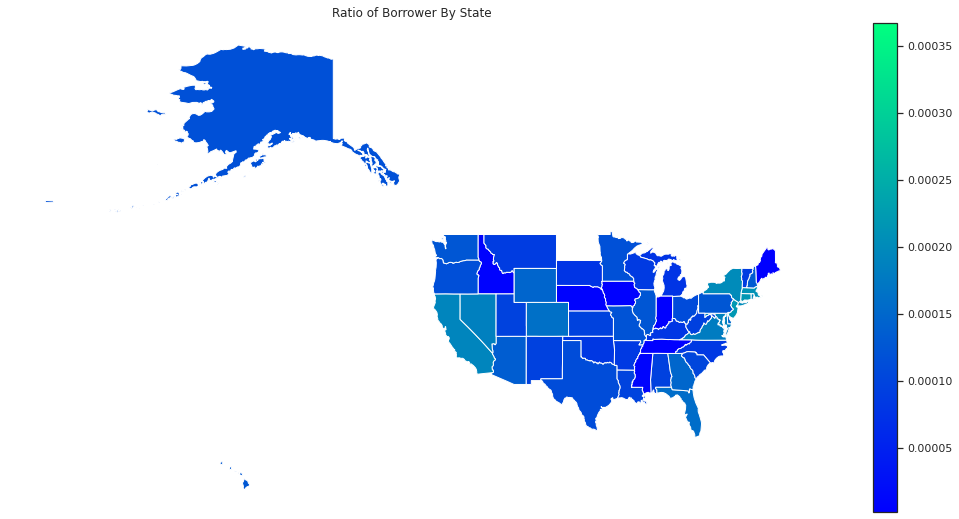

In [ ]:
# Calculate borrower amount by states
borrower_count = df_eda[['loan_amnt','addr_state']].groupby(by='addr_state', as_index=False).count()
borrower_count['state'] = borrower_count['addr_state'].apply(lambda x: abbr2state.get(x))
borrower_count = borrower_count.rename(columns={'loan_amnt': 'borrower_amnt'})

# Calculate the ratio of borrower over population in each state
member_ratio = borrower_count.merge(population_by_state, how='left', left_on='state', right_on='State')
member_ratio['ratio'] = member_ratio['borrower_amnt'] / member_ratio['2010 Population']
member_ratio = member_ratio[['addr_state', 'state', 'ratio']].sort_values('ratio', ascending=False).reset_index(drop=True)

member_ratio['state'] = member_ratio['addr_state'].apply(lambda x: abbr2state.get(x))
member_dict = member_ratio.set_index('state').drop(columns=['addr_state']).to_dict('index')

# Plot the map with the ratio of borrower over population as a gradual colormap
usmap['borrower_ratio'] = usmap['name'].apply(lambda x: member_dict.get(x).get('ratio') if member_dict.get(x) is not None else None)
usmap.plot(figsize=(20, 9), column='borrower_ratio', legend=True, cmap='winter')

plt.axis('off')
plt.title('Ratio of Borrower By State')
plt.show()

The map shows the borrowers ratio for each state, which can be an indicator of LendingClub's popularity in that state. The most frequent borrowers are from the northeast, with Connecticut, New Jersey and New York ranking first through third.

### 3.6 Average Annual Income Per Capita by State
Display a map of average annual income of borrowers from different states.

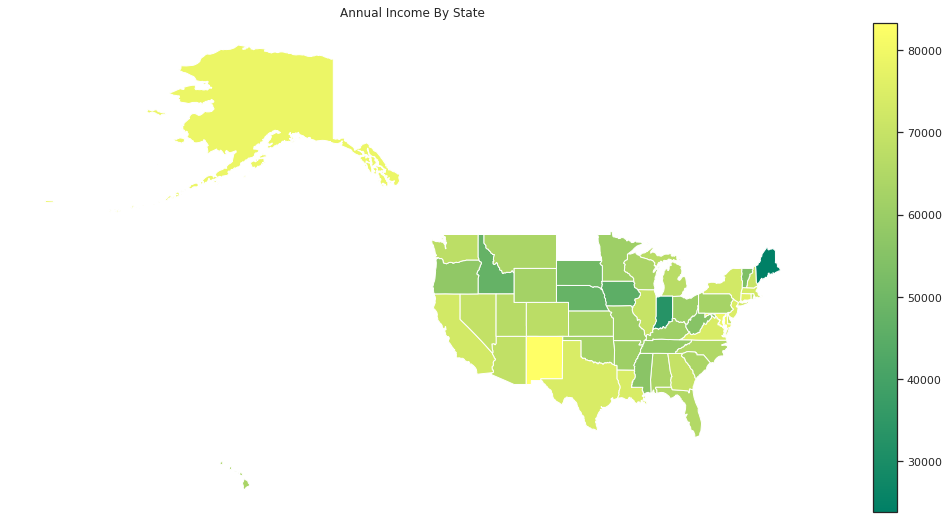

In [ ]:
# Calculate average annual income per capital by states
state_annual_income = df_eda[['annual_inc', 'addr_state']].groupby(by='addr_state', as_index=False).mean('annual_inc')
state_annual_income['state'] = state_annual_income['addr_state'].apply(lambda x: abbr2state.get(x))
income_dict = state_annual_income.set_index('state').drop(columns = ['addr_state']).to_dict('index')

# Plot the map with the average annual income as a gradual colormap
usmap['annual_inc'] = usmap['name'].apply(lambda x: income_dict.get(x).get('annual_inc') if income_dict.get(x) is not None else None)
usmap.plot(figsize=(20, 9), column='annual_inc', legend=True, cmap='summer')

plt.axis('off')
plt.title('Annual Income By State')
plt.show()

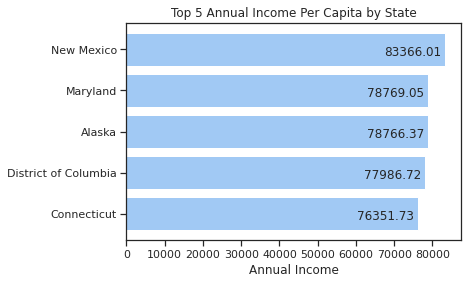

In [ ]:
# Plot top 5 result of above map for further analysis
top5_sai = state_annual_income.sort_values('annual_inc', ascending=False).reset_index(drop=True).head(5)

fig, ax = plt.subplots()
y_pos = np.arange(len(top5_sai['state']))
ax.barh(y_pos, top5_sai['annual_inc'])
ax.set_yticks(y_pos)
ax.set_yticklabels(top5_sai['state'])
ax.invert_yaxis()
ax.set_xlabel('Annual Income')
ax.set_title('Top 5 Annual Income Per Capita by State')

# Plot the text label of average annual income
for i, v in enumerate(top5_sai['annual_inc']):
    ax.text(v-16000, i+0.15, "{:.2f}".format(v))

plt.show()

The map shows how the borrowers' average annual income varies by state, suggesting that borrowers in different states have varied income levels. New Mexico, Maryland, and Alaska are the three states with the highest average annual income among borrowers.


### 3.7 Loan Amount by State
Display a map of loan amount of each states.


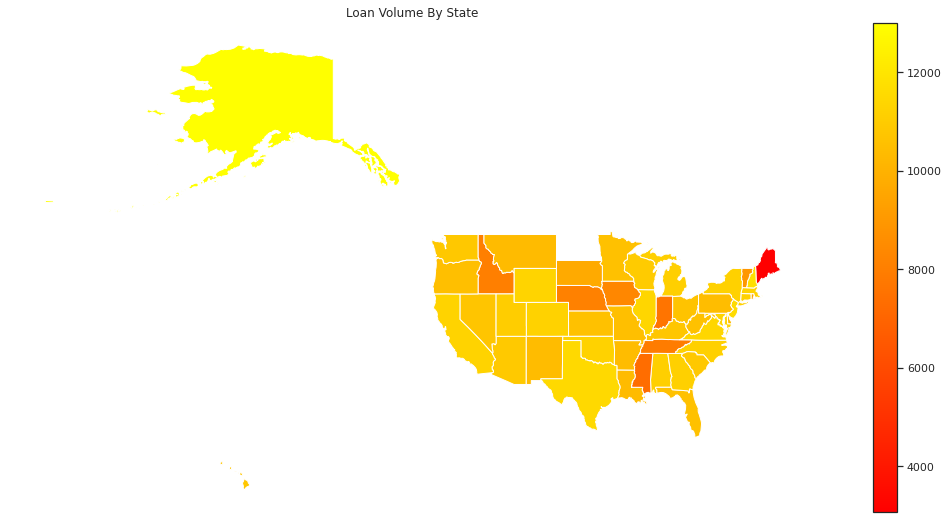

In [ ]:
# Calculate loan amount by states
state_loan_volumn = df_eda[['loan_amnt', 'addr_state']].groupby(by='addr_state', as_index=False).mean('loan_amntloan_amnt')
state_loan_volumn['state'] = state_loan_volumn['addr_state'].apply(lambda x: abbr2state.get(x))
loan_dict = state_loan_volumn.set_index('state').drop(columns = ['addr_state']).to_dict('index')

# Plot the map with the loan amount as a gradual colormap
usmap['loan_amnt'] = usmap['name'].apply(lambda x: loan_dict.get(x).get('loan_amnt') if loan_dict.get(x) is not None else None)
usmap.plot(figsize=(20, 9), column='loan_amnt', legend=True, cmap='autumn')

plt.axis('off')
plt.title('Loan Volume By State')
plt.show()

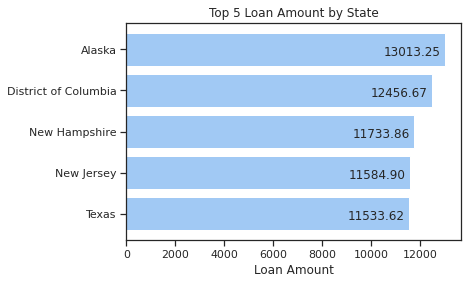

In [ ]:
# Plot top 5 result of above map for further analysis
top5_slv = state_loan_volumn.sort_values('loan_amnt',ascending=False).reset_index(drop=True).head()

fig, ax = plt.subplots()
y_pos = np.arange(len(top5_slv['state']))
ax.barh(y_pos, top5_slv['loan_amnt'])
ax.set_yticks(y_pos)
ax.set_yticklabels(top5_slv['state'])
ax.invert_yaxis()
ax.set_xlabel('Loan Amount')
ax.set_title('Top 5 Loan Amount by State')

# Plot the text label of average annual income
for i, v in enumerate(top5_slv['loan_amnt']):
    ax.text(v-2500, i+0.15, "{:.2f}".format(v))

plt.show()

The map shows the average loan amount per capita in each state. The top 3 states (or city) are Alaska, D.C. and New Hampshire. 

The above borrowers' feature descriptions can be utilized to learn about the characteristics of users in different states and to target future platform users.

### 3.8 Loan Amount over Years
Display a line chart of loan amount over years.

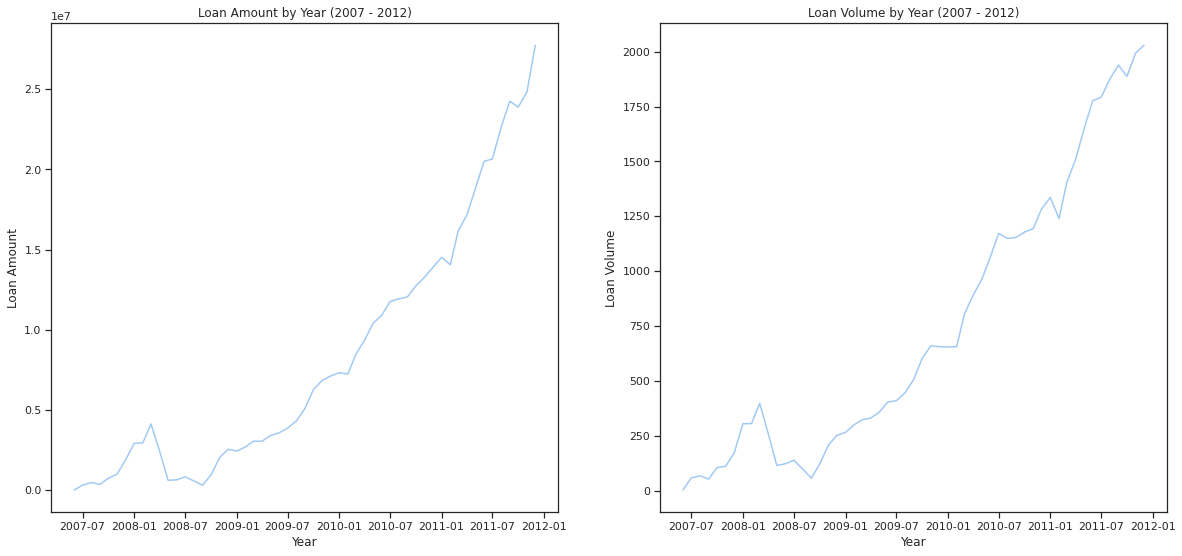

In [ ]:
# Calculate the total loan amount and loan volume by issue date
year_loan_amount = df_eda[['loan_amnt','issue_d']].groupby(by = 'issue_d', as_index=False).sum()
year_loan_volume = df_eda[['loan_amnt','issue_d']].groupby(by = 'issue_d', as_index=False).count()

# Plot time series plot of loan amount by year and loan volume by year side by side
plt.figure(figsize=(20, 9))

plt.subplot(1, 2, 1)
plt.plot(year_loan_amount['issue_d'], year_loan_amount['loan_amnt'])
plt.xlabel('Year')
plt.ylabel('Loan Amount')
plt.title('Loan Amount by Year (2007 - 2012)')

plt.subplot(1, 2, 2)
plt.plot(year_loan_volume['issue_d'], year_loan_volume['loan_amnt'])
plt.xlabel('Year')
plt.ylabel('Loan Volume')
plt.title('Loan Volume by Year (2007 - 2012)')

plt.show()

The loan amount vs. time shows a strong upward trend with at a slightly increasing rate. A noticeable peak occurred in the first season of 2008, which corresponds to the global financial crisis in 2007-2008. Millions of Americans were struggling with financial problems, while heavy losses forced banks to become stricter about loan disbursements, the chaos and fragility in the system caused dissatisfaction with commercial banks among borrowers. As a result, those in need of financial support were more likely to turn to peer-to-peer lending.

The financial crisis not only led a short-term peak in loan amount through Lending Club, but also created a thriving market for peer-to-peer lending in the long run.
The time consuming, lengthy and rigid procedures of "exposed" banks made way for more innovative lending and borrowing options. The result was the rise of peer-to-peer or marketplace lending which offer simplified and quick procedures, quick lending decisions and better interest rate deals for borrowers as well as lenders, with more transparency.


# **4. Model Training**

### 4.1 Drop Non-features
Drop columns that will not be used as feature in model training section.

In [ ]:
df_final = df_eda[feature_cols]

df_final.head()

,funded_amnt,term,emp_length,home_ownership,annual_inc,verification_status,dti,delinq_2yrs,fico_score,pub_rec,revol_bal,revol_util,total_acc,delinq_amnt,inq_last_6mths,credit_length,loan_status,int_rate
0,5000.0,36 months,10+ years,RENT,24000.0,Verified,27.65,0.0,737.0,0.0,13648.0,0.837,9.0,0.0,1.0,9830,paid,0.1065
1,2500.0,60 months,0-2 years,RENT,30000.0,Source Verified,1.00,0.0,742.0,0.0,1687.0,0.094,4.0,0.0,5.0,4627,default,0.1527
2,2400.0,36 months,10+ years,RENT,12252.0,Not Verified,8.72,0.0,737.0,0.0,2956.0,0.985,10.0,0.0,2.0,3682,paid,0.1596
3,10000.0,36 months,10+ years,RENT,49200.0,Source Verified,20.00,0.0,692.0,0.0,5598.0,0.210,37.0,0.0,1.0,5782,paid,0.1349
5,5000.0,36 months,2-5 years,RENT,36000.0,Source Verified,11.20,0.0,732.0,0.0,7963.0,0.283,12.0,0.0,3.0,2586,paid,0.0790


In [ ]:
print("The training dataset contains {} columns and {} rows.".format(df_final.shape[1], df_final.shape[0]))

The training dataset contains 18 columns and 40811 rows.


### 4.1 Convert Categorical Features
Use LabelEncoder to encode term, emp_length, home_ownership, verification_status, loan_status

In [ ]:
from sklearn.preprocessing import LabelEncoder

df_final["term"] = LabelEncoder().fit_transform(df_final["term"])
df_final["emp_length"] = LabelEncoder().fit_transform(df_final["emp_length"])
df_final["home_ownership"] = LabelEncoder().fit_transform(df_final["home_ownership"])
df_final["verification_status"] = LabelEncoder().fit_transform(df_final["verification_status"])
df_final["loan_status"] = LabelEncoder().fit_transform(df_final["loan_status"])

df_final.head()

,funded_amnt,term,emp_length,home_ownership,annual_inc,verification_status,dti,delinq_2yrs,fico_score,pub_rec,revol_bal,revol_util,total_acc,delinq_amnt,inq_last_6mths,credit_length,loan_status,int_rate
0,5000.0,0,1,4,24000.0,2,27.65,0.0,737.0,0.0,13648.0,0.837,9.0,0.0,1.0,9830,1,0.1065
1,2500.0,1,0,4,30000.0,1,1.00,0.0,742.0,0.0,1687.0,0.094,4.0,0.0,5.0,4627,0,0.1527
2,2400.0,0,1,4,12252.0,0,8.72,0.0,737.0,0.0,2956.0,0.985,10.0,0.0,2.0,3682,1,0.1596
3,10000.0,0,1,4,49200.0,1,20.00,0.0,692.0,0.0,5598.0,0.210,37.0,0.0,1.0,5782,1,0.1349
5,5000.0,0,2,4,36000.0,1,11.20,0.0,732.0,0.0,7963.0,0.283,12.0,0.0,3.0,2586,1,0.0790


### 4.2 Split Train/Test Set


In [ ]:
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

# Split the features and two labels
features = df_final[feature_cols[:-2]]
loan_status = df_final[feature_cols[-2:-1]]
int_rate = df_final[feature_cols[-1:]]

# Define undersample strategy, fit, and apply the transform
print("The count before undersampling the majority category: {}".format(Counter(loan_status.loan_status)))
features_rs, loan_status_rs = RandomUnderSampler(sampling_strategy='majority').fit_resample(features, loan_status)
print("The count after undersampling the majority category: {}".format(Counter(loan_status_rs.loan_status)))

# Split the train/test set for loan default probability
x_train_dp, x_test_dp, y_train_dp, y_test_dp = train_test_split(features_rs, loan_status_rs, test_size=0.1, random_state=42)
y_train_dp = y_train_dp['loan_status'].ravel()
y_test_dp = y_test_dp['loan_status'].ravel()

# Split the train/test set for loan interest rate
x_train_ir, x_test_ir, y_train_ir, y_test_ir = train_test_split(features, int_rate, test_size=0.1, random_state=42)
y_train_ir = y_train_ir['int_rate'].ravel()
y_test_ir = y_test_ir['int_rate'].ravel()

The count before undersampling the majority category: Counter({1: 34662, 0: 6149})
The count after undersampling the majority category: Counter({0: 6149, 1: 6149})


### 4.3 Loan Default Probability

#### 4.3.1 Logistic Regression
Logistic Regression is a “Supervised machine learning” algorithm that can be used to model the probability of a certain class or event. It is used when the data is linearly separable and the outcome is binary or dichotomous in nature. That means Logistic regression is usually used for Binary classification problems.

In [ ]:
from sklearn.linear_model import LogisticRegression

# Fit a logistic regression model
lr_clf = LogisticRegression(penalty="elasticnet", solver="saga", l1_ratio=0.7, max_iter=100000).fit(x_train_dp, y_train_dp)

print("The training accuracy is {}".format(lr_clf.score(x_train_dp, y_train_dp)))

The training accuracy is 0.5543910372244308


Confusion Matrix



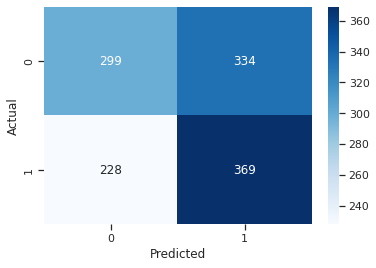


Classification Metrics

              precision    recall  f1-score   support

           0       0.57      0.47      0.52       633
           1       0.52      0.62      0.57       597

    accuracy                           0.54      1230
   macro avg       0.55      0.55      0.54      1230
weighted avg       0.55      0.54      0.54      1230



In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_pred_dp = lr_clf.predict(x_test_dp)

# Calculate and plot confusion matrix
cf_matrix = confusion_matrix(y_test_dp, y_pred_dp)

print("Confusion Matrix\n")
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual',fontsize=12)
plt.show()

# Report classification metrics
lr_report = classification_report(y_test_dp, y_pred_dp)

print("\nClassification Metrics\n")
print(lr_report)

From the above classification metrics, the accuracy is only 0.54, which is not very well according to the 50/50 paid/default split. However, the model has a recall of 0.62, which indicates that it is comparatively robust in predicting the correct paid loan request. With the overall low scores, we decided to apply PCA on the data and see if the PCA transformed data could help fit a better logistic regression model.

Explained variances in percentage:
[1.76635932e+01 1.17505340e+01 9.37131855e+00 7.75260130e+00
 7.19543485e+00 6.86205511e+00 6.62404327e+00 6.46668173e+00
 4.96609251e+00 4.60617574e+00 4.20056049e+00 4.03023707e+00
 3.38222756e+00 2.94659202e+00 2.18185264e+00 8.44415474e-34]



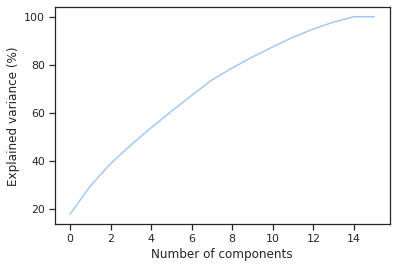

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Apply standardization
ss = StandardScaler().fit(x_train_dp)
x_train_dp_ss = ss.transform(x_train_dp)
x_test_dp_ss = ss.transform(x_test_dp)

# Apply PCA
pca = PCA().fit(x_train_dp_ss)
x_train_dp_pca = pca.transform(x_train_dp_ss)
x_test_dp_pca = pca.transform(x_test_dp_ss)

# Print explained variances in percentage
print("Explained variances in percentage:")
print(pca.explained_variance_ratio_*100)
print()

# Plot cumulative explained
plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")
plt.show()

As observed in the output and chart, we could conclude that more than 99.95% variance is explained with 15 components. Therefore, the next step is to reduce the number of compoenent of train and test dataset from 16 to 15. Then, we will retrain a logistic regression model on the PCA transformed train dataset and calculate the classification metrics with PCA transformed test dataset.

In [ ]:
# Rerun PCA with 15 components
pca = PCA(n_components=15).fit(x_train_dp_ss)
x_train_dp_pca = pca.transform(x_train_dp_ss)
x_test_dp_pca = pca.transform(x_test_dp_ss)

In [ ]:
# Fit a logistic regression model
lr_clf_pca = LogisticRegression(penalty="elasticnet", solver="saga", l1_ratio=0.7, max_iter=100000).fit(x_train_dp_pca, y_train_dp)

print("The training accuracy is {}".format(lr_clf_pca.score(x_train_dp_pca, y_train_dp)))

The training accuracy is 0.6357065413805566


Confusion Matrix



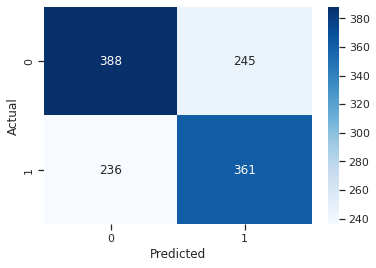


Classification Metrics

              precision    recall  f1-score   support

           0       0.62      0.61      0.62       633
           1       0.60      0.60      0.60       597

    accuracy                           0.61      1230
   macro avg       0.61      0.61      0.61      1230
weighted avg       0.61      0.61      0.61      1230



In [ ]:
y_pred_dp_pca = lr_clf_pca.predict(x_test_dp_pca)

# Calculate and plot confusion matrix
cf_matrix = confusion_matrix(y_test_dp, y_pred_dp_pca)

print("Confusion Matrix\n")
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual',fontsize=12)
plt.show()

# Report classification metrics
lr_pca_report = classification_report(y_test_dp, y_pred_dp_pca)

print("\nClassification Metrics\n")
print(lr_pca_report)

After applying PCA, the above classification metrics return better results. The accuracy increases to 0.61. In addition, both the precision and recall are much better than the previous model, indicating the increase in correctly predicting both paid and default loan request.

#### 4.3.2 Artificial Neural Network
Multilayer perceptrons, or more commonly referred to as artificial neural networks, are a combination of multiple neurons connected in the form a network. An artificial neural network has an input layer, one or more hidden layers, and an output layer. This is shown in the image below:
![](https://www.tibco.com/sites/tibco/files/media_entity/2021-05/neutral-network-diagram.svg)

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Define parameters and use grid search cross validation to find 
# the best set of paramter for artificial nueral network
params = {
    "hidden_layer_sizes": [(64, 32, 16), (128, 64, 32), (256, 128, 64)],
    "activation": ["logistic", "tanh", "relu"]
}
mlp_gs = GridSearchCV(estimator=MLPClassifier(max_iter=10000), param_grid=params, n_jobs=-1, cv=3).fit(x_train_dp, y_train_dp)

print("The best parameters are {}".format(mlp_gs.best_params_))
print("The training accuracy of the best parameters is {}".format(mlp_gs.best_score_))

The best parameters are {'activation': 'tanh', 'hidden_layer_sizes': (128, 64, 32)}
The training accuracy of the best parameters is 0.5533960065361926


Confusion Matrix



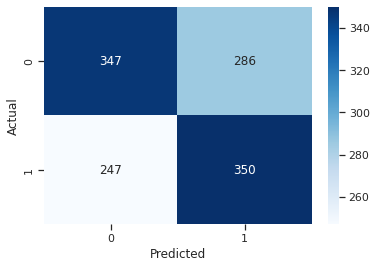


Classification Metrics

              precision    recall  f1-score   support

           0       0.58      0.55      0.57       633
           1       0.55      0.59      0.57       597

    accuracy                           0.57      1230
   macro avg       0.57      0.57      0.57      1230
weighted avg       0.57      0.57      0.57      1230



In [ ]:
from sklearn.metrics import classification_report

y_pred_dp = mlp_gs.best_estimator_.predict(x_test_dp)

# Calculate and plot confusion matrix
mlp_matrix = confusion_matrix(y_test_dp, y_pred_dp)

print("Confusion Matrix\n")
sns.heatmap(mlp_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual',fontsize=12)
plt.show()

# Report classification metrics
mlp_report = classification_report(y_test_dp, y_pred_dp)

print("\nClassification Metrics\n")
print(mlp_report)

From the above classification metrics, the accuracy is only 0.03 higher than the that of pre-PCA logistic regression model. Interestingly, we observed an even higher recall, which could also be identified from the darkest and lightest cells in the confusion matrix. 

In principal, the linear transformation performed by PCA can be performed just as well by by the input layer weights of the neural network, so it isn't strictly speaking necessary, especially when our neural network contains only 3 hidden layers.

#### 4.3.3 Naive Bayes
The Bayes Rule provides the formula to compute the probability of output (Y) given the input (X). In real-world problems, unlike the hypothetical assumption of having a single input feature, we have multiple X variables. When we can assume the features are independent of each other, we extend the Bayes Rule to what is called Naive Bayes.

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Fit a naive bayes model
nb_clf = GaussianNB().fit(x_train_dp, y_train_dp)

print("The training accuracy is {}".format(nb_clf.score(x_train_dp, y_train_dp)))

The training accuracy is 0.587097940007228


Confusion Matrix



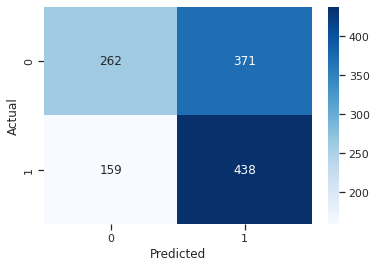


Classification Metrics

              precision    recall  f1-score   support

           0       0.62      0.41      0.50       633
           1       0.54      0.73      0.62       597

    accuracy                           0.57      1230
   macro avg       0.58      0.57      0.56      1230
weighted avg       0.58      0.57      0.56      1230



In [ ]:
from sklearn.metrics import classification_report

y_pred_dp = nb_clf.predict(x_test_dp)

# Calculate and plot confusion matrix
nb_matrix = confusion_matrix(y_test_dp, y_pred_dp)

print("Confusion Matrix\n")
sns.heatmap(nb_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual',fontsize=12)
plt.show()

# Report classification metrics
nb_report = classification_report(y_test_dp, y_pred_dp)

print("\nClassification Metrics\n")
print(nb_report)

From the above classification metrics, the accuracy is the same as that of Artificial Neural Network and only 0.03 higher than the that of pre-PCA logistic regression model. Surprisingly, we observed a recall of 0.73, which means the naive bayes model did really well in identifying true positive (paid loan request). However, the cost is that there are many false positive. Therefore, this model is quite problematic because it would approve many potentially defaulted loan requests.

#### 4.3.4 Random Forest
Random forest is a Supervised Machine Learning Algorithm that is used widely in Classification and Regression problems. It builds decision trees on different samples and takes their majority vote for classification and average in case of regression.
![](https://editor.analyticsvidhya.com/uploads/24015Random+Forest.jpg)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define parameters and use grid search cross validation to find 
# the best set of paramter for random forest classifier
params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [80, 160, 320]
}
rf_gs = GridSearchCV(estimator=RandomForestClassifier(), param_grid=params, n_jobs=-1, cv=3).fit(x_train_dp, y_train_dp)

print("The best parameters are {}".format(rf_gs.best_params_))
print("The training accuracy of the best parameters is {}".format(rf_gs.best_score_))

The best parameters are {'max_depth': 320, 'n_estimators': 200}
The training accuracy of the best parameters is 0.633537044505712


Confusion Matrix



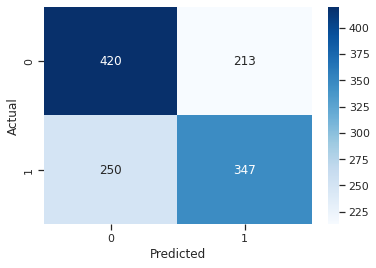


Classification Metrics

              precision    recall  f1-score   support

           0       0.63      0.66      0.64       633
           1       0.62      0.58      0.60       597

    accuracy                           0.62      1230
   macro avg       0.62      0.62      0.62      1230
weighted avg       0.62      0.62      0.62      1230



In [ ]:
from sklearn.metrics import classification_report

y_pred_dp = rf_gs.best_estimator_.predict(x_test_dp)

# Calculate and plot confusion matrix
rf_matrix = confusion_matrix(y_test_dp, y_pred_dp)

print("Confusion Matrix\n")
sns.heatmap(rf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual',fontsize=12)
plt.show()

# Report classification metrics
rf_report = classification_report(y_test_dp, y_pred_dp)

print("\nClassification Metrics\n")
print(rf_report)

From the above classification metrics, the accuracy is 0.01 higher than that of logistic regression model trained with PCA transformed dataset. This is inspiring because random forest, using bootstrap aggregating (bagging) algorithm, proves to improve the stability and accuracy without overfitting. Even though a accuracy of 0.63 is not optimal, we learned that, for classification problem in the future, random forest should be widely used when there is sufficient training time and computational power available.

### 4.4 Loan Interest Rate


#### 4.4.1 Linear Regression

Linear Regression  is another basic "supervised machine learning" algorithm. It is used to fit a linear function to features and output continuous output. The parameters of the linear function is estimated from data. \\
Assuming there are $p$ features $x_1$ to $x_p$ and $y$ is the dependent variable. We use the model below to find the relationship between features and label.
$$y=f(x_1, x_2, ···, x_p)+ɛ=\beta_0+\beta_1x_1+\beta_2x_2+···+\beta_px_p+ɛ$$

Linear Regression aims to find the best function $f(x)$ for the model, by minimizing the (Root) Mean Squared Error. This is the "ordinary least squares" linear regression (OLS).

In [ ]:
# Normalization on features
from sklearn.preprocessing import StandardScaler
StdScaler = StandardScaler()
x_train_ir_std = StdScaler.fit_transform(x_train_ir)
x_test_ir_std = StdScaler.fit_transform(x_test_ir)
y_train_ir_std = StdScaler.fit_transform(y_train_ir.reshape(-1, 1))
y_test_ir_std = StdScaler.fit_transform(y_test_ir.reshape(-1, 1))

The R-square of train data is 0.7590655026126424
The R-square of test data is 0.7622244562871867
The MAE is 0.013614909555721255
The MSE is 0.00031264119601016763
The RMSE is 0.017681662704908938


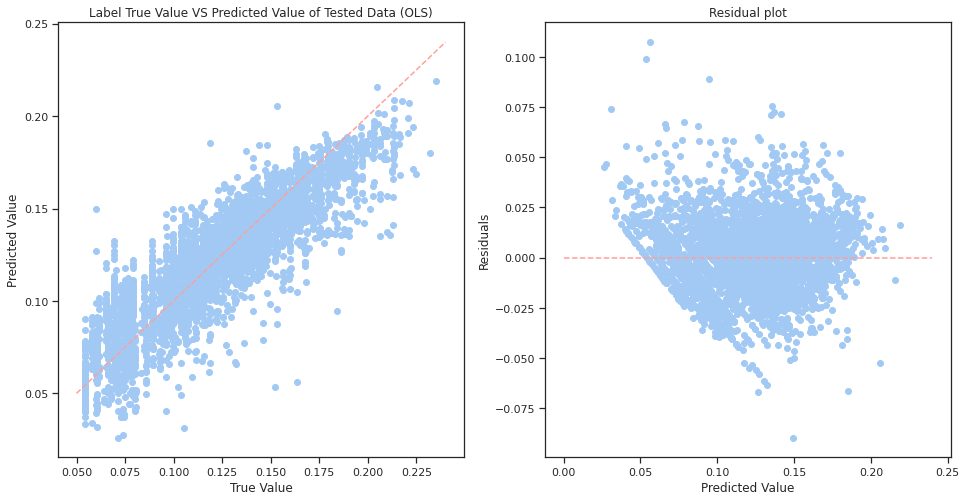

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
# Fit a linear regression model
clf = LinearRegression()
clf.fit(x_train_ir_std, y_train_ir_std)

# Predict label
y_pred_ir_std = clf.predict(x_test_ir_std)
y_pred_ir_inverse =  StdScaler.inverse_transform(y_pred_ir_std.reshape(-1, 1))
print("The R-square of train data is {}".format(clf.score(x_train_ir_std, y_train_ir_std)))
print("The R-square of test data is {}".format(clf.score(x_test_ir_std, y_test_ir_std)))
# Different error measures
print("The MAE is {}".format(mean_absolute_error(y_test_ir, y_pred_ir_inverse)))
print("The MSE is {}".format(mean_squared_error(y_test_ir, y_pred_ir_inverse)))
print("The RMSE is {}".format(np.sqrt(mean_squared_error(y_test_ir, y_pred_ir_inverse))))

# Plot test label and prediction result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
ax1.scatter(y_test_ir, y_pred_ir_inverse)
ax1.set_title('Label True Value VS Predicted Value of Tested Data (OLS)')
ax1.set_xlabel('True Value')
ax1.set_ylabel('Predicted Value')
# Add y = x to the plot 
x_comp =[0.01*x for x in range(5,25)]
y_comp = x_comp
ax1.plot(x_comp, y_comp, color='r', ls = '--')

# Residual plot
residuals = y_test_ir.reshape(-1, 1)-y_pred_ir_inverse
ax2.scatter(y_pred_ir_inverse,residuals)
ax2.set_xlabel("Predicted Value")
ax2.set_ylabel("Residuals")
ax2.set_title("Residual plot")
x_comp =[0.01*x for x in range(0,25)]
y_comp = [0 for x in x_comp]
ax2.plot(x_comp, y_comp, color='r', ls = '--')
plt.show()

To apply linear regression, we first normalize the data, which will make the feature coefficients more comparable. The test data R-square score is 0.76 and RMSE is 0.018, indicating the model has a fairly satisfying result in predicting loan interest rate using ordinary least squares linear regression. The test data R-square is nearly the same as train data R-square, even a bit lower, indicating overfitting does not exist. 

The residual plot reveals a triangular shape below 0, with nearly the same mean and variance of errors as positive errors in the center, but lower error levels at two ends of the prediction range than positive residuals. The residual is calculated as true minus predicted values, indicating that the model has a tendency to underpredict at both ends.

In [ ]:
# Print parameters of the fitted function
print("The intercept is {}".format(clf.intercept_))
print("The coefficient for features is \n {}".format(clf.coef_))

The intercept is [1.16537726e-15]
The coefficient for features is 
 [[ 2.84504296e-01  3.33560292e-01 -1.40196677e-02  2.03745067e-02
  -9.94985109e-05  1.67627255e-02 -6.30940364e-02  1.42913814e-02
  -6.97709029e-01 -2.20914880e-03 -4.73385490e-04  5.49606021e-02
  -4.31428274e-02 -6.33874492e-03  1.05618326e-01  2.58256939e-04]]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


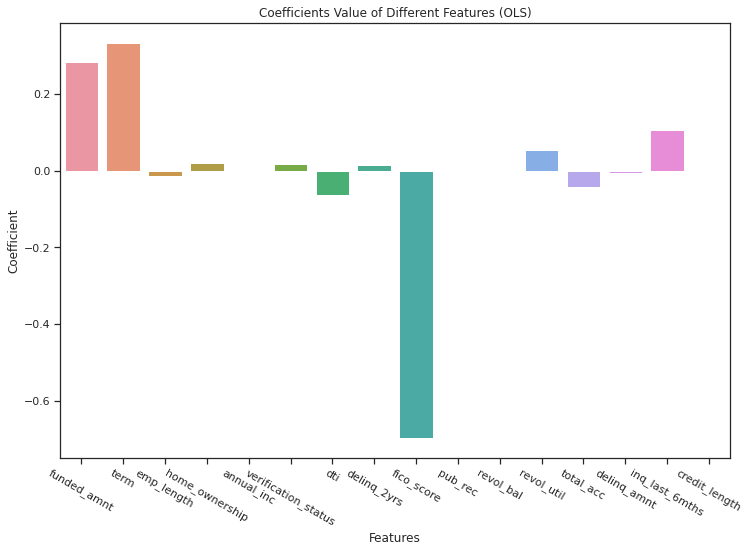

In [ ]:
# Plot the coefficients
fig, ax = plt.subplots(figsize = (12,8))
sns.barplot(features.columns, clf.coef_.flatten())
plt.setp(ax.get_xticklabels(), rotation=-30) 
plt.title('Coefficients Value of Different Features (OLS)')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.show()

The coefficient plot has shown that among 16 features, 12 of them are influential to loan interest rate. FICO score is the most significant features, which means the loan interest rate is highly negtively correlated with FICO score. The higher FICO score is, the more trustworthy the borrower is, then the less the loan interest rate is. This is reasonable as the bank tends to reduce loan interest rate to those who are credible. This result corresponds with the analysis in 3.3.

#### 4.4.2 Elastic Net Regression

Regularization can reduce model complexity to avoid overfitting and multicollinearity of the OLS regression. Regularization focus the classifier on the most contributing features by.
Lasso (L1 penalty) reduces overfitting when only a few features are predominent. Ridge (squared L2 penalty) avoid multicollinearity and shrink the large weights of similar value. ELastic Net combines Lasso and Ridge and take advantages of both.

The R-square of train data is 0.7354455129740403
The R-square of test data is 0.7378193854275616
The MAE is 0.014507948614224756
The MSE is 0.0003447304110031178
The RMSE is 0.01856691711090233


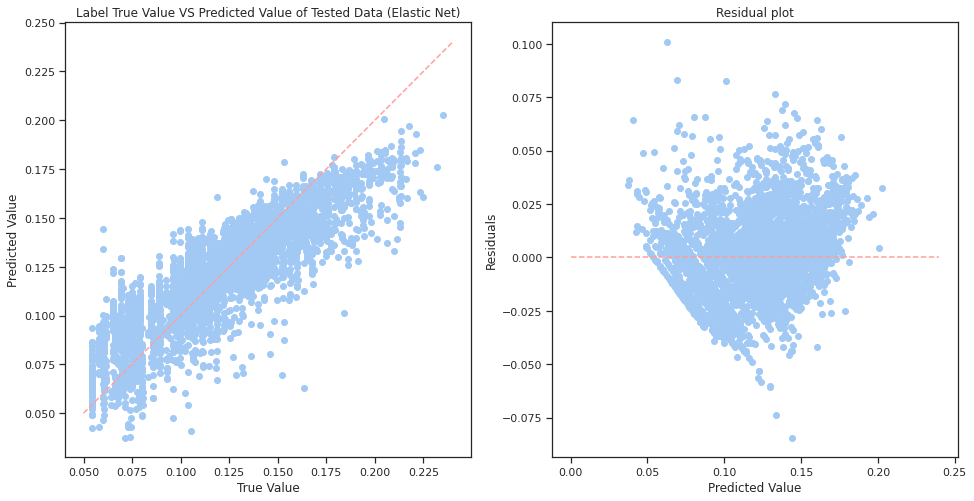

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso, Ridge
en_clf = ElasticNet(alpha = 0.1, l1_ratio = 0.5)
en_clf.fit(x_train_ir_std, y_train_ir_std)

y_pred_ir_std = en_clf.predict(x_test_ir_std)
y_pred_ir_inverse =  StdScaler.inverse_transform(y_pred_ir_std.reshape(-1, 1))
print("The R-square of train data is {}".format(en_clf.score(x_train_ir_std, y_train_ir_std)))
print("The R-square of test data is {}".format(en_clf.score(x_test_ir_std, y_test_ir_std)))
# Different error measures
print("The MAE is {}".format(mean_absolute_error(y_test_ir, y_pred_ir_inverse)))
print("The MSE is {}".format(mean_squared_error(y_test_ir, y_pred_ir_inverse)))
print("The RMSE is {}".format(np.sqrt(mean_squared_error(y_test_ir, y_pred_ir_inverse))))

# Plot test label and prediction result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
ax1.scatter(y_test_ir, y_pred_ir_inverse)
ax1.set_title('Label True Value VS Predicted Value of Tested Data (Elastic Net)')
ax1.set_xlabel('True Value')
ax1.set_ylabel('Predicted Value')
# Add y = x to the plot 
x_comp =[0.01*x for x in range(5,25)]
y_comp = x_comp
ax1.plot(x_comp, y_comp, color='r', ls = '--')

# Residual plot
residuals = y_test_ir.reshape(-1, 1)-y_pred_ir_inverse
ax2.scatter(y_pred_ir_inverse,residuals)
ax2.set_xlabel("Predicted Value")
ax2.set_ylabel("Residuals")
ax2.set_title("Residual plot")
x_comp =[0.01*x for x in range(0,25)]
y_comp = [0 for x in x_comp]
ax2.plot(x_comp, y_comp, color='r', ls = '--')
plt.show()


In [ ]:
# Print parameters of the fitted function
print("The intercept is {}".format(en_clf.intercept_))
print("The coefficient for features is \n {}".format(en_clf.coef_))

The intercept is [1.06844021e-15]
The coefficient for features is 
 [ 0.21730791  0.28490702 -0.          0.          0.          0.
 -0.          0.         -0.62457303  0.         -0.          0.03403184
 -0.         -0.          0.05340272 -0.        ]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


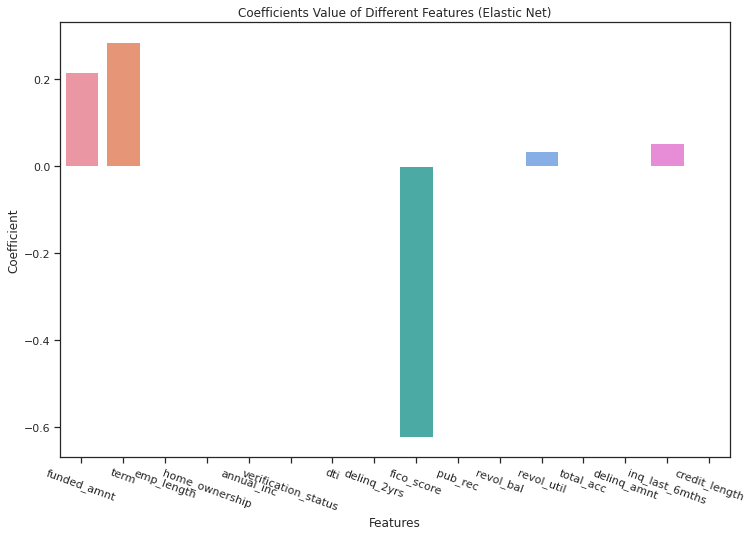

In [ ]:
fig, ax = plt.subplots(figsize = (12,8))
sns.barplot(features.columns, en_clf.coef_.flatten())
plt.setp(ax.get_xticklabels(), rotation=-20) 
plt.title('Coefficients Value of Different Features (Elastic Net)')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.show()


Regularization reduces model complexity to avoid overfitting. Although overfitting does not exist in our data, we still add regularization to discover its effect. We apply elastic net, which makes the most of Lasso and Ridge regression. Elastic net has pushed the model to a smaller number of feature weights and reduced the overall magnitutes of feature weights to some extent. This will reduce overfitting since only the most contributing features are used. The train data R-square has decreased since regularization has introduced bias to reduce model complexity.The test data R-squre is 0.74 and RMSE is 0.019 now since there is no overfitting in the original data. However, the reduction is acceptible. There are only 5 features remain, respectively funded amount, term, FICO score, revolving line utilization rate and inquiry amount in last 6 months. For the features which do not have significant effect, elastic net regression has pushed the weights of them to zero (the effect of Lasso Regression). And for the significant features, the regularization has leveraged their coefficients, shrinking every coefficient a bit and making the algorithm less extreme on FICO score.

#### 4.4.3 Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define parameters and use grid search cross validation to find 
# the best set of paramter for random forest regressor
params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [80, 160, 320]
}
rf_gs = GridSearchCV(estimator=RandomForestRegressor(), param_grid=params, n_jobs=-1, cv=5).fit(x_train_ir, y_train_ir)

print("The best parameters are {}".format(rf_gs.best_params_))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


The best parameters are {'max_depth': 160, 'n_estimators': 200}
The training accuracy of the best parameters is 0.8447482026207942


The R-square of train data is 0.9787706793194628
The R-square of test data is 0.844737544871148
The MAE is 0.010733212763351303
The MSE is 0.00020414815968452965
The RMSE is 0.01428804254208846


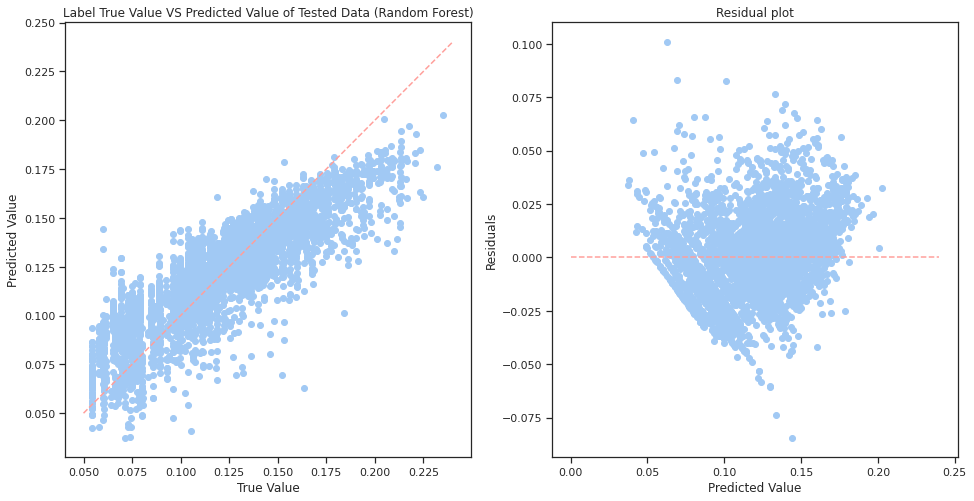

In [ ]:
y_pred_ir = rf_gs.best_estimator_.predict(x_test_ir)
print("The R-square of train data is {}".format(rf_gs.score(x_train_ir, y_train_ir)))
print("The R-square of test data is {}".format(rf_gs.score(x_test_ir, y_test_ir)))
# Different error measures
print("The MAE is {}".format(mean_absolute_error(y_test_ir, y_pred_ir)))
print("The MSE is {}".format(mean_squared_error(y_test_ir, y_pred_ir)))
print("The RMSE is {}".format(np.sqrt(mean_squared_error(y_test_ir, y_pred_ir))))

# Plot test label and prediction result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
ax1.scatter(y_test_ir, y_pred_ir_inverse)
ax1.set_title('Label True Value VS Predicted Value of Tested Data (Random Forest)')
ax1.set_xlabel('True Value')
ax1.set_ylabel('Predicted Value')
# Add y = x to the plot 
x_comp =[0.01*x for x in range(5,25)]
y_comp = x_comp
ax1.plot(x_comp, y_comp, color='r', ls = '--')

# Residual plot
residuals = y_test_ir.reshape(-1, 1)-y_pred_ir_inverse
ax2.scatter(y_pred_ir_inverse,residuals)
ax2.set_xlabel("Predicted Value")
ax2.set_ylabel("Residuals")
ax2.set_title("Residual plot")
x_comp =[0.01*x for x in range(0,25)]
y_comp = [0 for x in x_comp]
ax2.plot(x_comp, y_comp, color='r', ls = '--')
plt.show()

The R-square of random forest regressor is 0.84 and the RMSE is 0.014. Random Forest achieves the highest performance in predicting loan interest rate. This is because we have categorical features in our data set, such as term, employment length, home ownership status, verification status, loan status, which will work better on a binary classificatio model like random forest.

# **5. Challenges Faced**

### 5.1 Loan Default Probability

First, we observed that the percentage of labels for paid and default is not balanced. We have 85% label as paid and only 15% as default due to the natural that there are only a small fraction of loan request ended up to be defaulted. Therefore, we decided to resample the dataset and specifically downsample the majority label to ensure that we have 50/50 split for paid and default label.


Second, with the first attempt to train a logistic regression model, the model accuracy is only 0.54, which is only 0.04 better than a coin flip. Therefore, we decided to apply PCA to the dataset and as expected, we achieved an accuracy of 0.62 on the second attempt.


Finally, after trying a few more models, including Artificial Neural Network, Naive Bayes, Random Forest, we found that random forest, though requiring longer training time, is the best performed model that results in an accuracy of 0.63. However, such result is still not satisfying and we will discuss what could be done to further increase the accuracy in the potential next step section.



### 5.2 Loan Interest Rate

First, the necessarity of adding normalization. Although linear Regression without regularization is scale-invariant, it can be easily affected by feature value range after adding regularization. Therefore, we applied standardization to scale the data before the regression. In order to make the coefficients of features between OLS and Elatic Net more comparable, we also applied standarization to OLS.

Second, the selection of regularization parameter in Elastic Net Regression. In Scikit Learn, the parameter refer to the below cost function which we aim to minimize:
$$\frac{1}{2 * n} * ||y - Xw||^2_2 + \alpha * l_{1}ratio * ||w||_1 + 0.5 * \alpha * (1 - l_{1}ratio) * ||w||^2_2$$
After several experiments, we chose $\alpha$ to be 0.05 and l1 ratio to be 0.5, under which circumstance we do not sacrifice much R-square and the change in coefficients can be easily observed. However, to find the best regularization parameter, we should use validation curve.

# **6. Potential Next Steps**

### 6.1 Loan Default Probability

First, as mentioned in 5.1, downsampling the majority label was performed to ensure 50/50 split of paid and default labels. Although achieved a more balanced dataset, the amount of training data is greatly reduced. Therefore, we will could perform oversampling on the minority label since oversampling will increase the minority label to the same amount as majority label. However, the oversampling is basically randomly duplicating the rows with minority labels. As a result, we could combine oversampling and downsampling to find balance both in label distribution and data quality.

Second, the low accuracy of all models generally indicates that the models, including the random forest, are underfitted. As we learned in class, in order to combat underfitting, we should find more non-correlated features from the original dataset or try to get more real training instead of generating duplicating data. Unfortunately, we could not complete these tasks within this semester but we believe there are more to explore in the existing dataset in our hand and undiscovered dataset on the internet.

### 6.2 Loan Interest Rate

First, as mentioned in 5.2, we should use validation curve to find the best regularization parameter. Validation curves plots training and testing performance to regularization hyperparameter, which can help us find the best parameter of regularization.

Second, in regression analysis, residual plot is a simple way to expose a biased model. From the normally distributed errors assumption, the residuals should be randomly distributed around 0 and not show any trend as the predicted values change.Although we have achieved quite nice results in predicting the interest rates measured by MAE, MSE, RMSE and R-square, residual plots for both OLS regression and Elastic Net regression exhibit non-constant variance at different prediction levels. The residuals have the greatest variance in the middle and decrease towards the two ends. This indicates that the interest rates are not entirely linearly dependent on the features, thus we may include some non-linear relationship, like polynomials of a certain degree of some feature in the regression.  


Third, random Forest regression has generated the best results for our interest rate prediction. Compared to linear regression, Random Forests generally produce better results, work well on large datasets, and are able to work with missing data by creating estimates for them. However, they pose a major challenge that is that they can’t extrapolate outside unseen data. 
Future solutions can include combining predictors usting stacking. For example, create a stacking regressor using a linear model and a Random Forest Regressor. We can also consider other algorithms like SVM (Support Vector Machine) regression and Regression-Enhanced Random Forests (RERFs).